In [1]:
import os
import gc
import time
import pickle
import kaggle
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, metrics
import lightgbm as lgb
from textblob import TextBlob

path = "F:\\Pratik\\LearningZone\\Competitions\\Avito_Demand_Prediction_Challenge\\RawData"
os.chdir(path)

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
train_df = pd.read_csv('train_translated.csv', parse_dates=['activation_date'])
test_df = pd.read_csv('test_translated.csv', parse_dates=['activation_date'])

In [2]:
total_df = pd.read_csv('total_translated_05152018.csv', parse_dates=['activation_date'])

In [14]:
svd_df = pd.read_csv('total_translated_05122018.csv', parse_dates=['activation_date'])

In [ ]:
train_df['dow'] = train_df['activation_date'].dt.weekday
test_df['dow'] = test_df['activation_date'].dt.weekday

In [3]:
total_df['dow'] = total_df['activation_date'].dt.weekday

In [ ]:
# Function to extract features from them:
@delayed
def period_features(x):
    x['dow_first_day_display'] = x['date_from'].dt.weekday
    x['dow_last_day_display'] = x['date_to'].dt.weekday
    x['time_btwn_placed_display'] = (x['date_from'] - x['activation_date']).dt.days
    x['duration_display'] = (x['date_to'] - x['date_from']).dt.days
    return x

# Passing the train data through period_features fn:
periods_train = period_features(periods_train)
%time periods_train = periods_train.compute()

# Passing the test data through period_features fn:
periods_test = period_features(periods_test)
%time periods_test = periods_test.compute()

In [4]:
cat_vars = ["en_region", "en_city", "en_parent_category_name", "en_category_name", "user_type","image_top_1","en_param1","en_param2","en_param3"]

In [5]:
def label_encoding(train_data, categorical_feature_names):
    le = preprocessing.LabelEncoder() # Defining Label Encoder
    train_cat_features = np.array(train_data[categorical_feature_names])
    train_data_array = le.fit_transform(train_cat_features[:,0])
    for i in range(1,train_cat_features.shape[1]):
        train_data_array = np.column_stack((train_data_array, le.fit_transform(train_cat_features[:,i])))
        
    train_cat_data_df = pd.DataFrame(train_data_array, columns=categorical_feature_names)
    return train_cat_data_df[categorical_feature_names]

In [6]:
total_df[['en_param1','en_param2','en_param3','image_top_1']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [ ]:
train_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)
test_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

In [7]:
total_df['en_param1'] = total_df['en_param1'].map(str)
total_df['en_param2'] = total_df['en_param2'].map(str)
total_df['en_param3'] = total_df['en_param3'].map(str)

In [ ]:
train_df['en_param1'] = train_df['en_param1'].map(str)
train_df['en_param2'] = train_df['en_param2'].map(str)
train_df['en_param3'] = train_df['en_param3'].map(str)

In [ ]:
test_df['en_param1'] = test_df['en_param1'].map(str)
test_df['en_param2'] = test_df['en_param2'].map(str)
test_df['en_param3'] = test_df['en_param3'].map(str)

In [8]:
Catg_Var_LE = label_encoding(total_df, cat_vars)

In [ ]:
Catg_Var_LE_train = label_encoding(train_df,cat_vars)
Catg_Var_LE_test = label_encoding(test_df,cat_vars)

In [9]:
# Dropping the rows on which One-Hot Encoding has been performed
total_df = total_df.drop(Catg_Var_LE.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
total_df = pd.concat([total_df,Catg_Var_LE], axis=1)

In [ ]:
# Dropping the rows on which One-Hot Encoding has been performed
train_df = train_df.drop(Catg_Var_LE_train.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
train_df = pd.concat([train_df,Catg_Var_LE_train], axis=1)

In [ ]:
# Dropping the rows on which One-Hot Encoding has been performed
test_df = test_df.drop(Catg_Var_LE_test.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
test_df = pd.concat([test_df,Catg_Var_LE_test], axis=1)

In [ ]:
total_df['price_new'] = np.log(total_df['price']+0.001)
total_df["price_new"].fillna(np.nanmean(total_df["price_new"].values), inplace=True)

In [17]:
train_df = total_df[total_df['set'] == 'train']
test_df = total_df[total_df['set'] == 'test']

In [15]:
target = 'deal_probability'
predictors = ['dow', 'en_region', 'en_city',
       'en_parent_category_name', 'en_category_name', 'user_type', 'price_new', 'description_num_chars',
       'description_num_words', 'description_num_unique_words',
       'description_words_vs_unique', 'combine_param1n2n3_num_chars',
        'title_num_chars', 'item_seq_number',
       'title_num_words','image_top_1','en_param1','en_param2','en_param3',
        'count_by_byuser','count_by_parent_category_byuser','percent_parent_category_byuser',
             'count_by_parent_category_city_byuser','count_by_parent_category_city','percent_parent_category_city_byuser',
             'count_by_category_city_byuser','count_by_category_city','percent_category_city_byuser',
             'count_by_parent_category_region_byuser','count_by_parent_category_region','percent_parent_category_region_byuser',
             'count_by_category_region_byuser','count_by_category_region','percent_category_region_byuser',
             'meanprice_category_name_city','stdprice_category_name_city','meanprice_parent_category_name_city','stdprice_parent_category_name_city',
             'meanprice_category_name_region','stdprice_category_name_region','meanprice_parent_category_name_region','stdprice_parent_category_name_region']

# getting the title_svd cols:
title_cols = [col for col in svd_df.columns if 'title' in col]
title_cols.remove('title')

# getting the desc_svd cols:
desc_cols = [col for col in svd_df.columns if 'desc' in col]
desc_cols.remove('description')

# putting all of them together:
predictors = predictors + title_cols + desc_cols

In [16]:
total_df = pd.concat([total_df, svd_df[title_cols], svd_df[desc_cols]], axis=1)

In [18]:
# del svd_df
# del prev_df
#del total_df
gc.collect()

24

In [ ]:
['title_words_vs_unique','combine_param1n2n3_words_vs_unique','combine_param1n2n3_num_unique_words','combine_param1n2n3_num_words','title_num_unique_words']

### Standarizing data:

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [ ]:
numeric_cols = ['price_new','description_num_chars','description_num_words','description_num_unique_words',
                'description_words_vs_unique','combine_param1n2n3_num_chars','combine_param1n2n3_num_words',
               'combine_param1n2n3_num_unique_words','combine_param1n2n3_words_vs_unique','title_num_chars',
               'title_words_vs_unique']

In [ ]:
total_df[numeric_cols] = sc.fit_transform(total_df[numeric_cols])

In [ ]:
#Splitting the data for model training#
dev_X = train_df.iloc[:-200000,:]
val_X = train_df.iloc[-200000:,:]

# # Splitting based on date:
# dev_X = train_df[train_df['activation_date'] <= '2017-03-23']
# val_X = train_df[train_df['activation_date'] > '2017-03-23']

In [22]:
def run_lgb(train_X, val_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values, feature_name=predictors)
    lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values, feature_name=predictors)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgtrain, lgval], valid_names=['train','valid'],
                      early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    #model = lgb.cv(params, lgtrain, 5000, verbose_eval=20, nfold=5, stratified=True)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [ ]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [ ]:
num_leaves = [20, 25, 30, 35, 40]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
bst_results = []
for num_lv in num_leaves:
    for lr in learning_rate:
        new_params = {"num_leaves" : num_lv, "learning_rate" : lr}
        params.update(new_params)
        lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
        lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
        evals_result = {}
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
        bst_results.append(params, )

In [ ]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 30,
        learning_rate = 0.1,
        bagging_fraction = 0.7,
        feature_fraction = 0.7,
        bagging_frequency = 5,
        bagging_seed = 2018,
        verbosity = -1)

In [ ]:
params_opt = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], "num_leaves" : [20, 25, 30, 35, 40]}

In [ ]:
gridSearchCV = GridSearchCV(estimator = model, 
    param_grid = params_opt, verbose=1)

In [ ]:
gridSearchCV.fit(train_df[predictors],train_df[target])

In [ ]:
gridSearchCV.grid_scores_

In [19]:
from sklearn.model_selection import KFold

In [20]:
kf = KFold(n_splits=5)

In [21]:
gc.collect()

0

In [10]:
prev_df = pd.read_csv('total_translated_05102018.csv')

In [11]:
prev_df = prev_df[['description_num_chars', 'description_num_words', 'description_num_unique_words', 'description_words_vs_unique', 'combine_param1n2n3_num_chars', 'title_num_chars', 'title_num_words']]

In [12]:
total_df = pd.concat([total_df, prev_df], axis=1)

In [23]:
columns = ['fold','train_score','valid_score']
final_stats = pd.DataFrame(columns=columns)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
n=1
for train_index, val_index in kf.split(train_df):
    train_data, val_data = train_df.loc[train_index], train_df.loc[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    kfold = str(n)+'_fold'
    print("Modeling for {}".format(kfold))
    model, result = run_lgb(train_data, val_data)
    results = {'fold'       : kfold,
               'train_score': result['train']['rmse'][model.best_iteration],
               'valid_score': result['valid']['rmse'][model.best_iteration]       
        }
    final_stats = final_stats.append(results, ignore_index=True)
    print("Done modeling...")
    print("Generating predictions....")
    test_df[kfold+'_predictions'] = model.predict(test_df[predictors], num_iteration=model.best_iteration)
    n=n+1

Modeling for 1_fold
Training until validation scores don't improve for 100 rounds.
[20]	train's rmse: 0.233929	valid's rmse: 0.234247
[40]	train's rmse: 0.230504	valid's rmse: 0.231009
[60]	train's rmse: 0.228748	valid's rmse: 0.229425
[80]	train's rmse: 0.227651	valid's rmse: 0.228544
[100]	train's rmse: 0.226754	valid's rmse: 0.22785
[120]	train's rmse: 0.225983	valid's rmse: 0.227308
[140]	train's rmse: 0.225383	valid's rmse: 0.226965
[160]	train's rmse: 0.224787	valid's rmse: 0.226603
[180]	train's rmse: 0.224267	valid's rmse: 0.22633
[200]	train's rmse: 0.223786	valid's rmse: 0.22609
[220]	train's rmse: 0.223404	valid's rmse: 0.225975
[240]	train's rmse: 0.222994	valid's rmse: 0.225803
[260]	train's rmse: 0.222608	valid's rmse: 0.225651
[280]	train's rmse: 0.222213	valid's rmse: 0.225521
[300]	train's rmse: 0.22186	valid's rmse: 0.225415
[320]	train's rmse: 0.2215	valid's rmse: 0.225287
[340]	train's rmse: 0.221198	valid's rmse: 0.225232
[360]	train's rmse: 0.220822	valid's rmse: 

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Modeling for 2_fold
Training until validation scores don't improve for 100 rounds.
[20]	train's rmse: 0.234042	valid's rmse: 0.234273
[40]	train's rmse: 0.230617	valid's rmse: 0.231248
[60]	train's rmse: 0.228842	valid's rmse: 0.229716
[80]	train's rmse: 0.227699	valid's rmse: 0.22879
[100]	train's rmse: 0.226788	valid's rmse: 0.228121
[120]	train's rmse: 0.225981	valid's rmse: 0.227532
[140]	train's rmse: 0.225353	valid's rmse: 0.227133
[160]	train's rmse: 0.224784	valid's rmse: 0.226811
[180]	train's rmse: 0.224293	valid's rmse: 0.226576
[200]	train's rmse: 0.223806	valid's rmse: 0.226349
[220]	train's rmse: 0.223382	valid's rmse: 0.226188
[240]	train's rmse: 0.222956	valid's rmse: 0.226008
[260]	train's rmse: 0.222536	valid's rmse: 0.225853
[280]	train's rmse: 0.222128	valid's rmse: 0.225722
[300]	train's rmse: 0.221792	valid's rmse: 0.225634
[320]	train's rmse: 0.22143	valid's rmse: 0.225534
[340]	train's rmse: 0.221106	valid's rmse: 0.225485
[360]	train's rmse: 0.2208	valid's rmse

In [24]:
final_stats

,fold,train_score,valid_score
0,1_fold,0.199558,0.223518
1,2_fold,0.198924,0.223722
2,3_fold,0.201483,0.223420
3,4_fold,0.197826,0.223524
4,5_fold,0.198153,0.223469


In [25]:
final_stats.to_csv("../Results/Stats_5foldcv_clipvalue_newfeats_05152018_2.csv", index=False)

In [26]:
np.average(final_stats['train_score'])

0.19918872823482203

In [27]:
np.average(final_stats['valid_score'])

0.22353057039481278

In [28]:
test_df['deal_probability'] = np.average(test_df[['1_fold_predictions','2_fold_predictions','3_fold_predictions','4_fold_predictions','5_fold_predictions']], axis=1)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
test_df['deal_probability'] = np.clip(np.array(test_df['deal_probability']),0.0,1.0)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df.deal_probability[test_df['deal_probability'] < 0] = abs(test_df.deal_probability[test_df['deal_probability'] < 0])

In [ ]:
gc.collect()

In [ ]:
model, result = run_lgb(dev_X, val_X)

### Defining entire model:

In [ ]:
params = {'max_depth' : -1,
          'objective': 'regression', 
          'num_leaves': 40, 
          'learning_rate': 0.1, 
          'bagging_fraction': 1, 
          'bagging_freq': 1, 
          'feature_fraction': 0.8, 
          'metric' : 'rmse'}

In [ ]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.01, 0.05, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [35,40,45,50],
    'boosting_type' : ['gbdt'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'bagging_fraction' : [0.7,0.75],
    #'reg_alpha' : [1,1.2],
    #'reg_lambda' : [1,1.2,1.4],
    }

In [ ]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 40,
        learning_rate = 0.1,
        bagging_fraction = 1,
        feature_fraction = 0.8,
        bagging_freq = 1,
        bagging_seed = 2018,
        verbosity = -1)

In [ ]:
grid = GridSearchCV(model, gridParams, verbose=1, cv=5, n_jobs=-1)

In [ ]:
grid.fit(train_df[predictors],train_df[target])

In [ ]:
params.update(grid.best_params_)

In [ ]:
test_df['deal_probability'] = grid.predict(test_df[predictors])

In [ ]:
grid.best_params_

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
test_df['deal_probability'] = model.predict(test_df[predictors])

In [ ]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

In [30]:
test_df[['item_id','deal_probability']].to_csv('../Results/5foldcv_clipvalue_newfeats_05152018_2.csv', index=False)

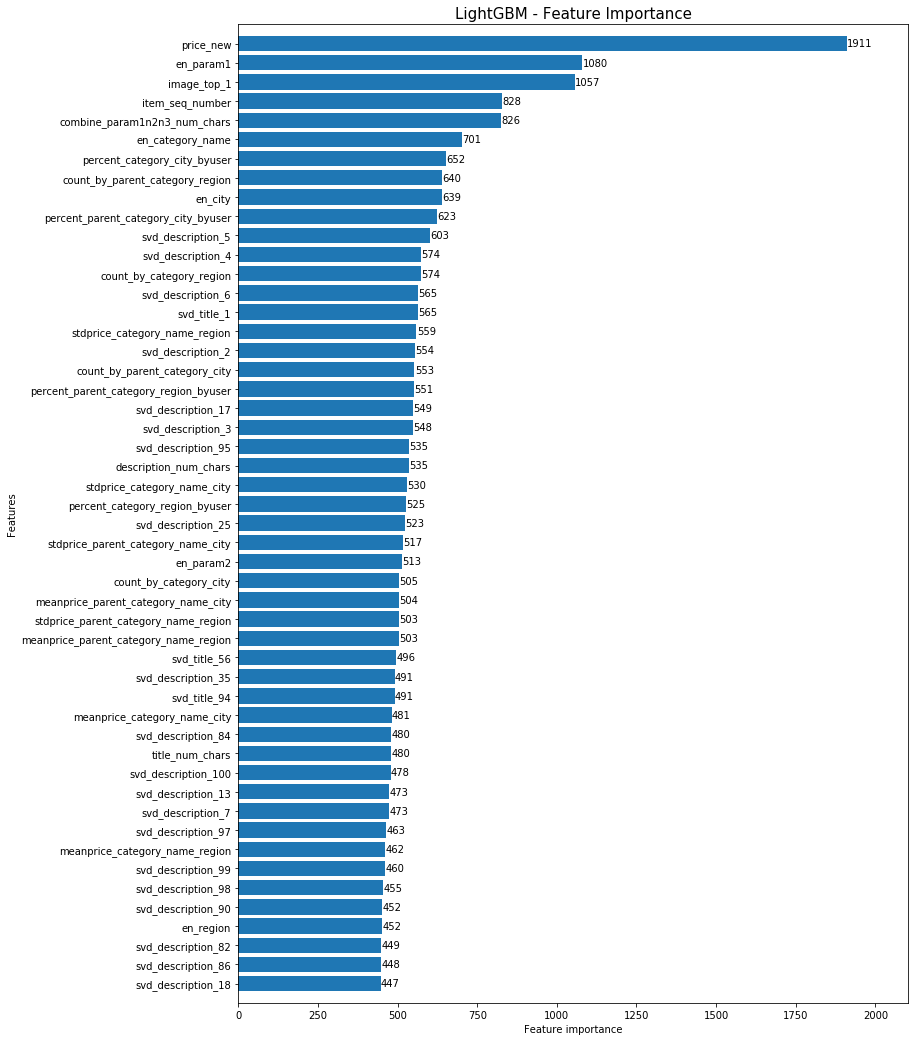

In [31]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
#lgb.plot_importance(model)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()
fig.savefig('5foldcv_clipvalue_newfeats_05152018.png')

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
#lgb.plot_importance(model)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Running XGBoost:

In [ ]:
import xgboost as xgb

In [ ]:
len(val_X)

In [ ]:
len(dev_X)

In [ ]:
train_dmatrix = xgb.DMatrix(dev_X[predictors],dev_X[target])
valid_dmatrix = xgb.DMatrix(val_X[predictors],val_X[target])

In [ ]:
def run_xgb(train_dmatrix, valid_dmatrix):
    params = {
        "objective" : "reg:linear",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    evals_result = {}
    evallist = [(train_dmatrix,'train'), (valid_dmatrix, 'eval')]
    model = xgb.train(params, train_dmatrix, 5000, evallist, early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [ ]:
model, result = run_xgb(train_dmatrix, valid_dmatrix)

In [ ]:
test_dmatrix = xgb.DMatrix(test_df[predictors])

In [ ]:
preds = model.predict(test_dmatrix)

In [ ]:
test_df['deal_probability'] = preds

In [ ]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

In [ ]:
test_df[['item_id','deal_probability']].to_csv('base_submission_xgb_05072018.csv', index=False)

### Submission to kaggle via API:

In [32]:
!kaggle competitions submit -c avito-demand-prediction -f ../Results/5foldcv_clipvalue_newfeats_05152018_2.csv -m "5CV newfeats clipping to unit interval - 05152018_2"

Successfully submitted to Avito Demand Prediction Challenge


In [ ]:
!kaggle competitions submit -c avito-demand-prediction -f Results/base_submission_xgb_05072018.csv -m "base submission xgb model"